In [2]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries

import os
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.api as sm
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

TISSUES="Adipose-Subcutaneous,Adipose-Visceral(Omentum),Artery-Aorta,Artery-Tibial,Brain-Caudate(basalganglia),Brain-Cerebellum,Cells-Transformedfibroblasts,Esophagus-Mucosa,Esophagus-Muscularis,Heart-LeftVentricle,Lung,Muscle-Skeletal,Nerve-Tibial,Thyroid,WholeBlood,Skin-NotSunExposed(Suprapubic),Skin-SunExposed(Lowerleg)"
GENE="ENSG00000124767.6"
CHROM=6
START=38671094

Populating the interactive namespace from numpy and matplotlib


/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


In [3]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz 

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GB\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

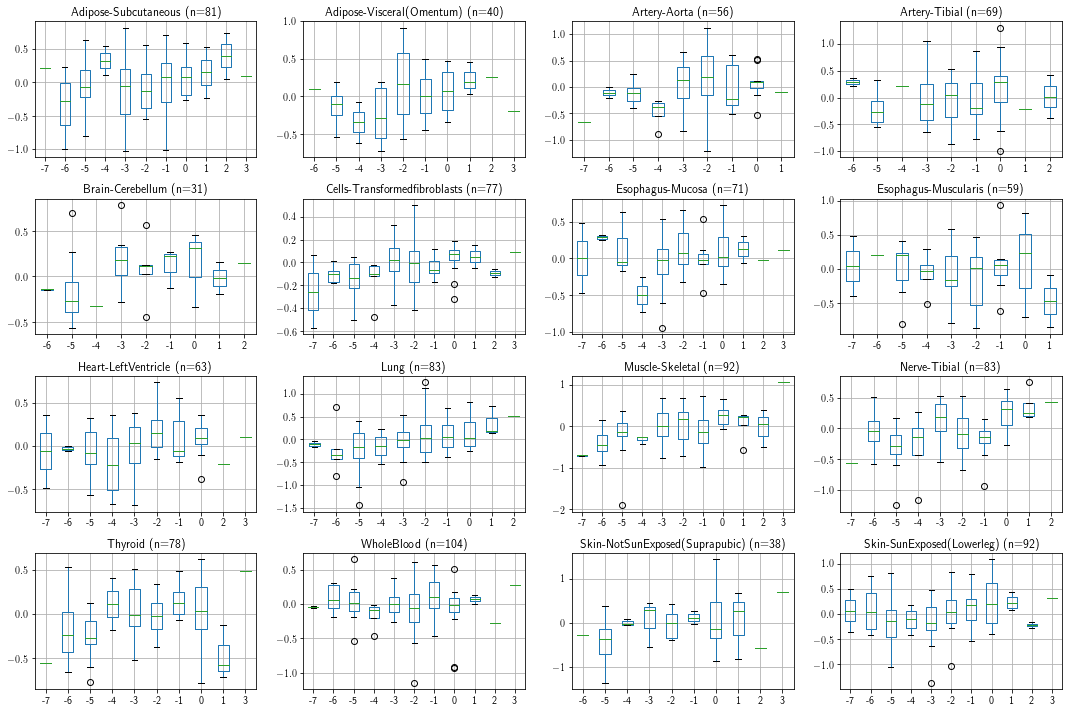

In [8]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

fig = plt.figure()
fig.set_size_inches((15, 10))
fignum = 1

for t in TISSUES.split(","):
    if "Caudate" in t: continue
    expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
    data = pd.merge(strgt, expr)
    ax = fig.add_subplot(4, 4, fignum)
    data.boxplot(column="expr", by="str", ax=ax);
    ax.set_xlabel("", size=12)
    ax.set_ylabel("", size=12)
    ax.set_title(t + " (n=%s)"%data.shape[0])
    plt.suptitle("");
    fignum += 1
    #fig.savefig("pdfs/%s_%s.pdf"%(GENE,t))
plt.tight_layout()
fig.savefig("pdfs/GLO1_promoter_polyT.pdf")